# ImageCLEF Medical Caption Task 2019

We will be making a convolutional neural network for the [Image CLEF 2019 Concept Detection Task](https://www.imageclef.org/2019/medical/caption/) (using the Keras and Tensorflow libraries). It is a multi-label classifiaction task, by identifying medical terms in radiology images. We will score the model with the script provided on the competition's website- and compare that score to a baseline- and we will write our predictions for the test dataset into a csv file.

## Data

* A training set of 56,629 training images.

* A validation set of 14,157 validation images.

* A test set of 10,000 images.

* Two csv files with the image IDs and their correct tags fom the training and validating images, respectively.

* A csv file that matches the tag IDs to their corresponding  name.

We do not have the correct tags of the test set; our goal is to find them.

### Importing necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data reading
* We read the csv files, containing the correct tags of our images, and we append the filetypes to the image names.
* We also read the concepts' IDs.
* We reset the index, because the index column will be needed later.

In [5]:
tr_c = pd.read_csv('train_concepts.csv')
tr_c.reset_index(level=0, inplace=True)
tr_c.image = tr_c.image + '.jpg'
len_tr = len(tr_c.index)

val_c = pd.read_csv('val_concepts.csv')
val_c.reset_index(level=0, inplace=True)
val_c.image = val_c.image + '.jpg'
len_val = len(val_c.index)

str_c = pd.read_csv('string_concepts.csv', sep='\t', header=None, names=['code', 'name'], index_col=0)


### Filetype checking
We make sure that all the images are `.jpg`s, to make sure that we appended the right filetypes to every image.

In [6]:
from os import listdir
from os.path import splitext

def find_extensions(path):
    images = listdir(path)
    filetypes = {}
    for image in images:
        ext = splitext(image)[1]
        if ext in filetypes:
            filetypes[ext] += 1
        else:
            filetypes[ext] = 1
    return filetypes

find_extensions('training-set'), find_extensions('validation-set')

({'.jpg': 56629}, {'.jpg': 14157})

### Getting a sense of the data

In [7]:
val_c.head(10)

,index,image,tags
0,0,ROCO_CLEF_64017.jpg,C0001074;C3203359;C0041618
1,1,ROCO_CLEF_39073.jpg,C0027530;C1610719;C0065967;C1704258;C0883242;C...
2,2,ROCO_CLEF_18028.jpg,C1265876;C1293134;C0029053;C0034579;C0025066;C...
3,3,ROCO_CLEF_02052.jpg,C0040426;C1962945;C0043299;C0036849;C0150312
4,4,ROCO_CLEF_67927.jpg,C0184666;C4085643;C4049705;C4049706;C4321335;C...
5,5,ROCO_CLEF_43280.jpg,C0751437;C1561543;C1561540;C0037004;C0441633
6,6,ROCO_CLEF_20357.jpg,C0039985;C0032326;C0224338
7,7,ROCO_CLEF_15263.jpg,C1709311;C1524073;C1261381;C0812144;C3540851;C...
8,8,ROCO_CLEF_24380.jpg,C0032005;C1285092
9,9,ROCO_CLEF_70369.jpg,C3244072;C0741968;C1704258;C0005847;C0009924;C...


### Beggining the Data Exploration
Counting tags and plotting two images, together with their tag IDs (with their corresponding names).

A total number of 5528 tags was found in the string_concepts.csv file

Left image's details:
ROCO_CLEF_01943.jpg
['C0412555;C0041618;C0005847']
['obstetric ultrasounds', 'medical sonography', 'blood vessel structure']

Right image's details:
ROCO_CLEF_04563.jpg
['C0032005;C0935598;C1548801;C0006826;C0000723;C0020663']
['nervous system', 'sagittal planes set', 'external', 'malignancy', 'preferred abbreviation', 'preoptico-hypothalamic region']


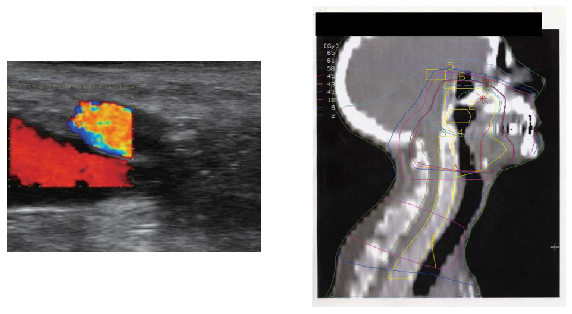

In [8]:
print(f'A total number of {str_c.size} tags was found in the string_concepts.csv file', end='\n\n')

from PIL import Image

image_name = 'ROCO_CLEF_01943.jpg'
image_name2 = 'ROCO_CLEF_04563.jpg'

tags = tr_c.loc[tr_c.image == image_name].tags.values
print('Left image\'s details:')
print(image_name)
print(tags)
print([str_c.loc[x][0] for x in tags[0].split(';')], end='\n\n')

tags = tr_c.loc[tr_c.image == image_name2].tags.values
print('Right image\'s details:')
print(image_name2)
print(tags)
print([str_c.loc[x][0] for x in tags[0].split(';')])

plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
img = Image.open('training-set/'+ image_name)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
img = Image.open('training-set/'+ image_name2)
plt.imshow(img)
_ = plt.axis('off')

### Getting basic data statistics
* We can see that, since there are 1.580 tags that appear only once; there is a label imbalance. It will be very difficult for our neural network to predict those tags.
* We can see the minimum, the median and the maximum number of tags per image.
* We can also see the tags that appear the most times.

In [9]:
tags_per_row = [x.split(";") for x in tr_c['tags'].values]
tags_per_row_lengths = [len(x) for x in tags_per_row]

print('For the training dataset:')
print(f'Minimun tag number per image is {min(tags_per_row_lengths)}')
print(f'Median tag number per image is {np.median(tags_per_row_lengths)}')
print(f'Maximum tag number per image is {max(tags_per_row_lengths)}', end='\n\n')

unique_tags = {}
for tags in tags_per_row:
    for tag in tags:
        if tag in unique_tags:
            unique_tags[tag] += 1
        else:
            unique_tags[tag] = 1

NUM_CLASSES = len(str_c.index)
print(f'On the training dataset there are {len(unique_tags)}',
      f'tags and there is a total of {NUM_CLASSES} tags.', end='\n\n')

top_codes = pd.Series(unique_tags, name='count_of_tags').sort_values(ascending=False).to_frame()
top_codes['name'] = str_c.loc[top_codes.index]

print(f'There are {len(top_codes.loc[top_codes.count_of_tags == 1].index)} tags that appear only one time.')

top_codes.head()

For the training dataset:
Minimun tag number per image is 1
Median tag number per image is 5.0
Maximum tag number per image is 72

On the training dataset there are 5216 tags and there is a total of 5528 tags.

There are 1530 tags that appear only one time.


,count_of_tags,name
C0441633,6733,diagnostic scanning
C0043299,6321,x-ray procedure
C1962945,6318,radiogr
C0040395,6235,tomogr
C0034579,6127,pantomogr


## Generators
We will use a trick for the generators, since ImageDataGenerator does not support multi-label images.
### Training Generator
* We define the images' height, width and the batch size the generators will use.
* We will rescale the data to \[0, 1\] values and, to avoid overfitting, we will use image transformation with the training generator.
    * horizontal flip of the images
    * rotation
    * height shift
    * width shift
    * zooming
* We will create a generator with the `flow_from_dataframe` method, on the previous ImageDataGenerator object.
    * We set the directory where our images are.
    * The trick we use is that the generator returns the image and the index of the DataFrame that corresponds to that image, from which we will get the tags.
    * We shuffle the images returned, which will reduce overfitting. This will result in some epochs not getting all of the images and getting some twice, but it is better that way.

In [10]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
batch_size = 32

training_image_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1
)
training_generator = training_image_data_generator.flow_from_dataframe(
    dataframe=tr_c,
    directory='training-set/',
    x_col='image',
    y_col='index',
    class_mode='other',
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    batch_size=batch_size
)

Found 56629 validated image filenames.


### Validation images Generator
We do the same to create a generator for the validation images, with the only difference being that we do not transform the images, only rescale them.

In [11]:
val_image_data_generator = ImageDataGenerator(
    rescale=1./255
)
val_generator = val_image_data_generator.flow_from_dataframe(
    dataframe=val_c,
    directory='validation-set/',
    x_col='image',
    y_col='index',
    class_mode='other',
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    batch_size=batch_size
)

Found 14157 validated image filenames.


### MultiLabelBinarizer
* Normally, we would fit only the tags in the training set, but if we fit the MultiLabelBinarizer with the tags met in the training dataset only, it would yield an error when we try to transform the tags from the validating dataset, because it includes some tags not present in the training dataset (and thus not fitted). They are working on that bug it seems.
* The MultiLabelBinarizer will transform the rows from tags, separated by `;`, to an array (of size 5528, the total number of tags fitted) of binary values, with `1` in the positions that correspond to the tags for that specific image.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb_fitted = mlb.fit([str_c.index])

### From index to binary tags
Here we define a function that uses the previous Generators and the MultiLabelBinarizer, to transform the `(image, index)` batches to `(image, binary_tag_array)` batches.

In [13]:
def multilabel_flow_from_dataframe(data_generator, mlb):
    for x, y in data_generator:
        y_multi = mlb.transform(
            [tags.split(";") for tags in tr_c.iloc[y]['tags'].values]
        )
        yield x, y_multi

training_multilabel_generator = multilabel_flow_from_dataframe(
    training_generator, mlb_fitted
)

val_multilabel_generator = multilabel_flow_from_dataframe(
    val_generator, mlb_fitted
)

### Visualizing generator
We print the results yielded from the previous generator, to make sure we are passing the correct values to the neural networks.

We get a batch of 32 normalized pics, with a (256, 256, 3) shape.
We also get a batch of 32 labels, with a (5528,) shape.

The first array of tags is:
[0 0 0 ... 0 0 0]

Those tags are:
['underarm', 'inferior maxillary bone', 'bone', 'teeth set', 'retained tooth', 'visible lesion', 'alesion', 'maxilla bone complex']


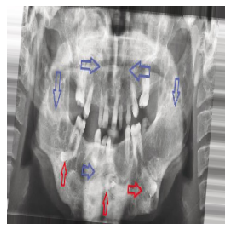

In [14]:
x,y = next(training_multilabel_generator)

print(f'We get a batch of {x.shape[0]} normalized pics, with a {x.shape[1:]} shape.')
print(f'We also get a batch of {y.shape[0]} labels, with a {y.shape[1:]} shape.', end='\n\n')

print('The first array of tags is:')
print(y[0], end='\n\n')

print('Those tags are:')
print([str_c.loc[tag][0] for tag in mlb.inverse_transform(y)[0]])

fig = plt.figure(figsize=(4, 4))
plt.imshow(x[0])
_ = plt.axis('off')

## Baseline classifier
For a baseline we are using the Dummy Classifier. It is an easy way for us to predict based on the class distribution.
* Here we use a MultiLabelBinarizer with sparse output array, which we could not do for the neural network.
* It might seem strange that we are fitting the classifier with a list with zeros as the X value, but let us not forget that the X value is irrelevant here; we want the baseline to learn to predict only from the tags (classes).
* We will use a basic f1_score to measure. Below we will use a different approach, but we expect to get a sense of the improvement we get with the neural network.

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

tags_per_row_val = [x.split(";") for x in val_c['tags'].values]

dummy_clf = DummyClassifier()
mlb_sparse = MultiLabelBinarizer(sparse_output=True)
mlb_sparse_fitted = mlb_sparse.fit([str_c.index])

# transforming the tags found in the validating dataset
mlb_dummy_transformed_val = mlb_sparse_fitted.transform(tags_per_row_val)

# X value is irrelevant, use zeros as placeholder
dummy_clf.fit([0] * mlb_dummy_transformed_val.shape[0], mlb_dummy_transformed_val)

# using zeros as placeholder again
y_pred = dummy_clf.predict([0] * len(val_c.index))

f1_score(mlb_dummy_transformed_val, y_pred, average='macro')

0.0011016133988168443

#### Most predicted tags
Let us see which tags are predicted the most by the classifier and how they match to the actually most used tags.

In [19]:
most_predicted_tags={}
for tag_set in y_pred.toarray():
    for i, x in enumerate(tag_set):
        if x>0:
            tag_xx = mlb.classes_[i]
            if tag_xx in most_predicted_tags:
                most_predicted_tags[tag_xx] += 1
            else:
                most_predicted_tags[tag_xx] = 1

* We can see that the Dummy Classifier did a good job of predicting the most used tags, more than the rest, thus it is a good baseline. It also did a good job of predicting a similar number of tags, for each image, as the actual dataset.
* To understand it better, we can see how many times each tag was predicted by the Dummy Classifier and how many times it was used in the training dataset, below.

*Note*: The training dataset has more images that the validating one, for which we predicted the tags, so it is expected for the tags there to have a bigger count.

In [27]:
predicted_values = pd.Series(most_predicted_tags, name='predicted_count')\
                    .sort_values(ascending=False).to_frame()
print('\nThe average tag number per image, with the Dummy Classifier, is ', 
      predicted_values.predicted_count.sum() // y_pred.shape[0], '.')
predicted_values.join(top_codes).head(20)


The average tag number per image, with the Dummy Classifier, is  6 .


,predicted_count,count_of_tags,name
C0441633,1692,6733.0,diagnostic scanning
C0043299,1585,6321.0,x-ray procedure
C1962945,1583,6318.0,radiogr
C0817096,1489,5981.0,thoracics
C0040395,1461,6235.0,tomogr
C0034579,1437,6127.0,pantomogr
C0040405,1362,5801.0,x-ray computer assisted tomography
C1548003,1269,5159.0,radiograph
C0772294,1165,4512.0,alesion
C0221198,1165,4513.0,visible lesion


## Neural network

### Starting simple

We just flatten the images, feed them to a dense layer with 64 neurons and the feed that to the output layer, with a neuron number the same as the number of classes we want to predict.

* Since we have a multi-label classification problem, the final score for each class should be independent of each other, so instead of softmax we will have the sigmoid activation function.
* We use a binary crossentropy loss function.

*Note*: Some tags could be cleaned to yield better results.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import tensorflow_hub as hub

In [48]:
model_simple = Sequential([
    Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='sigmoid')
])

model_simple.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_simple.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_15 (Dense)             (None, 5528)              359320    
Total params: 12,942,296
Trainable params: 12,942,296
Non-trainable params: 0
_________________________________________________________________


We fit the generators for 10 epochs and we use 1/5 of the number of images we could use, to execute it in a reasonable time.<br>
We save both this and the next model to a `models` directory.

In [53]:
epochs = 10

simple_history = model_simple.fit_generator(
    generator = training_multilabel_generator,
    steps_per_epoch=len_tr // batch_size // 5,
    epochs=epochs,
    validation_data=val_multilabel_generator,
    validation_steps=len_val // batch_size // 5,
    max_queue_size=20
)

model_cnn.save('models/model_simple.h5')

Epoch 1/10
353/353 [==============================] - 335s 949ms/step - loss: 0.6153 - accuracy: 0.9938 - val_loss: 0.5393 - val_accuracy: 0.9989
Epoch 2/10
353/353 [==============================] - 338s 957ms/step - loss: 0.4781 - accuracy: 0.9989 - val_loss: 0.4222 - val_accuracy: 0.9989
Epoch 3/10
353/353 [==============================] - 328s 928ms/step - loss: 0.3761 - accuracy: 0.9989 - val_loss: 0.3339 - val_accuracy: 0.9989
Epoch 4/10
353/353 [==============================] - 299s 848ms/step - loss: 0.2990 - accuracy: 0.9989 - val_loss: 0.2670 - val_accuracy: 0.9989
Epoch 5/10
353/353 [==============================] - 355s 1s/step - loss: 0.2405 - accuracy: 0.9989 - val_loss: 0.2160 - val_accuracy: 0.9989
Epoch 6/10
353/353 [==============================] - 383s 1s/step - loss: 0.1955 - accuracy: 0.9989 - val_loss: 0.1765 - val_accuracy: 0.9989
Epoch 7/10
353/353 [==============================] - 351s 993ms/step - loss: 0.1605 - accuracy: 0.9989 - val_loss: 0.1456 - val_a

We see, from the adopted code below, that the accuracy reaches a very high level (we will explain why below) and the loss keeps decreasing. Since there is no sign of overfitting- and the loss keeps decreasing- we could fit it for more epochs.

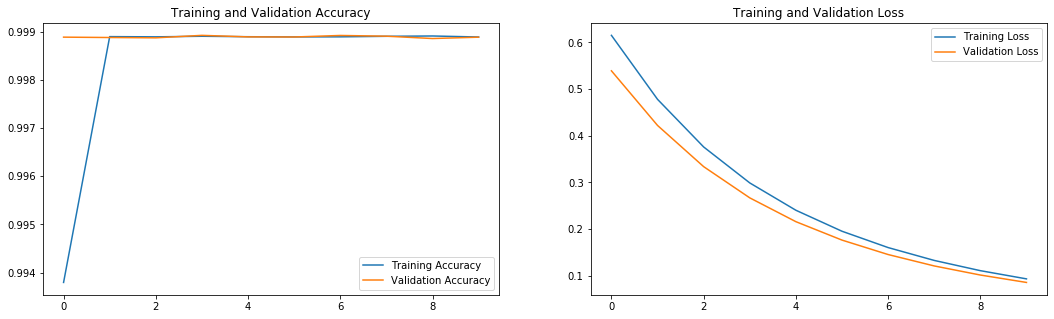

In [56]:
accuracy = simple_history.history['accuracy']
val_accuracy = simple_history.history['val_accuracy']

loss = simple_history.history['loss']
val_loss = simple_history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
_ = plt.title('Training and Validation Loss')

### Using CNNs

Here we use a more advanced neural network which, after testing, seems to fare better than similar ones.
* We utilise convolutional filters (of 5x5 size), we use Max Pooling to "zoom out" a bit on our filters and we use a dropout layer to further limit overfitting (a total of three times).
* We increase the number of filters in each step, since the input size decreases and it is less computationally demanding. The first layer of filters uses as input the image and the next ones use the zoomed-out filters as input (after the dropout).
* We flatten the output of the last layer, after the last filter- MaxPooling- and Dropout (so after the feature extraction), to feed that to our Dense layer that will feed that to another, smaller, Dense layer, to help with the classification, which will be done in the last Dense layer.

In [49]:
model_cnn = Sequential([
    Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='sigmoid'),
])


model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)       

In [54]:
cnn_history = model_cnn.fit_generator(
    generator = training_multilabel_generator,
    steps_per_epoch=len_tr // batch_size // 5,
    epochs=epochs,
    validation_data=val_multilabel_generator,
    validation_steps=len_val // batch_size // 5,
    max_queue_size=20
)

model_cnn.save('models/model_cnn.h5')

Epoch 1/10
353/353 [==============================] - 1681s 5s/step - loss: 0.0194 - accuracy: 0.9925 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 2/10
353/353 [==============================] - 1633s 5s/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 3/10
353/353 [==============================] - 1680s 5s/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 4/10
353/353 [==============================] - 1685s 5s/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0064 - val_accuracy: 0.9989
Epoch 5/10
353/353 [==============================] - 29900s 85s/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 6/10
353/353 [==============================] - 1950s 6s/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 7/10
353/353 [==============================] - 1655s 5s/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0066 - val_accurac

The accuracy again reaches a very high level and the loss seems to stay the same, after the first epoch; even inceasing slightly. Still, it is way lower than the previous model, so we will be using this model for our predictions.

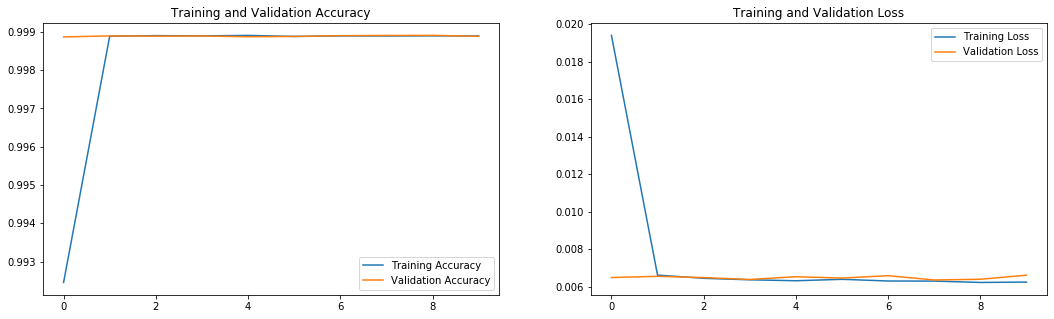

In [169]:
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
_ = plt.title('Training and Validation Loss')

### Using pretrained
We could do something more advanced, use a pretrained model. Here we use a model from the Tensorflow Hub as a feature extractor and then feed a Dense layer with 512 neurons and a, final, classification layer, as done above.

In [36]:
url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_extract = hub.KerasLayer(url, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], trainable=False)

In [40]:
pretrained_model = Sequential([
    feature_extract,  
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='sigmoid')
])

pretrained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
pretrained_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_25 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_26 (Dense)             (None, 5528)              2835864   
Total params: 25,687,736
Trainable params: 3,884,952
Non-trainable params: 21,802,784
_________________________________________________________________


#### Skipping the fit
It would take many days to run. Should anyone have better resources, the below code works.

In [ ]:
'''
pretrained_history = pretrained_model.fit_generator(
    generator = training_multilabel_generator,
    steps_per_epoch=len_tr // batch_size,
    epochs=epochs,
    validation_data=val_multilabel_generator,
    validation_steps=len_val // batch_size,
    max_queue_size=20
)
'''

## Accuracy
It seems that the above two models that we fitted have incredible accuracy, for this kind of problem. Well, that is not exactly the case. The accuracy gets so high because we want to predict an array 5528 tags, with each image having a median of 5 tags, while all the rest are 0. So, of course, the accuracy will be very high just by predicting mostly zeros.<br>
That seems to be a usual problem in multi-label classification neural networks. We should not change the loss funcion, which leaves us with changing the metric the model uses. Here we are trying out a possible solution found online; using the f1-score, since that is what we are trying to maximize. For 1 epoch it did not seem to work properly.

In [110]:
import keras_metrics as km

model_cnn_cat = Sequential([
    Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='sigmoid'),
])

model_cnn_cat.compile(loss='binary_crossentropy', optimizer='adam', metrics=[km.f1_score()])

cnn_cat_history = model_cnn_cat.fit_generator(
    generator = training_multilabel_generator,
    steps_per_epoch=len_tr // batch_size // 10,
    epochs=1,
    validation_data=val_multilabel_generator,
    validation_steps=len_val // batch_size // 10,
    max_queue_size=20
)

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
176/176 [==============================] - 868s 5s/step - loss: 0.0314 - f1_score: 0.0000e+00 - val_loss: 0.0065 - val_f1_score: 0.0000e+00


### F1 scoring the models
Let us proceed to scoring the models. We load the best model we have fitted; the second one.

*Note*: there were multiple attempts to use Google's colab to run more complex networks, without the image limitations (1/5) we had above, but the free version kept disconnecting and it was not actually that faster.

In [19]:
from tensorflow.keras.models import load_model

model_cnn = load_model('models/model_cnn.h5')

### Validation image generator
We use a similar approach to above, only now we have a batch size of 1 and we return the images in the same order. Also, we do not need the labels in the format we used above. We will only pass the image to our model to predict and we will use the tag names to write them to our file.

In [71]:
val_image_data_generator_f1_test = ImageDataGenerator(
    rescale=1./255
)
val_generator_f1_test = val_image_data_generator_f1_test.flow_from_dataframe(
    dataframe=val_c,
    directory='validation-set/',
    x_col='image',
    y_col='index',
    class_mode='other',
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    sort=False,
    shuffle=False,
    batch_size=1
)

Found 14157 validated image filenames.


### Prediction vizualization
* To see what our model predicts, we will plot an image and then also plot the predicted tags' names.
* Since the model returns values \[0, 1\], depending on how confident it is that that is the right tag for that image, we need a treshold, to only keep the tags for which it is mostly sure. After some testing it seems that 0.12 is a good treshold.
* Of course, by looking at the predicted tags for various images, we can see that the model mostly predicts the top tags used, but that is to be expected.

materials 0.14891878
pantomogr 0.32736337
tomogr 0.3080966
x-ray computer assisted tomography 0.30498245
visible lesion 0.15910324
diagnostic scanning 0.3069391
contrasting 0.1602003
alesion 0.15887934
lobus 0.12060392
thoracics 0.19295236


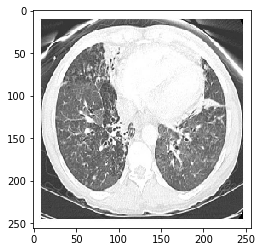

In [110]:
treshold = 0.12
image, _ = next(val_generator_f1_test)
plt.imshow(image[0])
for position, prediction in enumerate(model_cnn.predict(np.array([image[0]]))[0]):
    if prediction > treshold:
        print(str_c.loc[mlb.classes_[position]].values[0], prediction)

### Image prediction file
We will use the scoring script used in the competition, found in the [competition web page](https://www.imageclef.org/2019/medical/caption/). It compares two files that have the same images, one that has the predicted tags (for us it is the one we will make) with a file the has the ground-truth tags (for us the `val_concepts.csv`)

* We reset the generator to start returning images from the beginning of the file.
* We loop through the images our generator has and for each one:
    * We get the image name and write that (without the filetype), following that with a tab character, as instructed in the competition's page.
    * We proceed to write the tags predicted, that are above our aforementioned treshold, separated by a semicolon.

In [410]:
val_generator_f1_test.reset()
with open('predictions_val.csv', 'w') as file:
    for validation_size in range(len(val_generator_f1_test)):
        image, index = next(val_generator_f1_test)
        file.write(val_c.loc[index].image.values[0][:-4]+ '\t')
        first_prediction = True
        for position, prediction in enumerate(model_cnn.predict(np.array([image[0]]))[0]):
            if prediction > treshold:
                if first_prediction == False:
                    file.write(';')
                file.write(mlb.classes_[position])
                first_prediction = False
        file.write('\n')

### File visualization
To better understand the two files that we will compare with the script, let us see them in a DataFrame.

In [453]:
predictions = pd.read_csv('predictions_val.csv', names=['image', 'predicted_tags'], sep='\t', index_col='image')
actual = pd.read_csv('val_concepts.csv', index_col='image')
predictions.join(actual).head()

,predicted_tags,tags
image,,
ROCO_CLEF_64017,C0221198;C0441633;C0772294,C0001074;C3203359;C0041618
ROCO_CLEF_39073,C0034579;C0040395;C0221198;C0441633;C0772294,C0027530;C1610719;C0065967;C1704258;C0883242;C...
ROCO_CLEF_18028,C0009924;C0034579;C0040395;C0040405;C0221198;C...,C1265876;C1293134;C0029053;C0034579;C0025066;C...
ROCO_CLEF_02052,C0043299;C0817096;C1548003;C1962945,C0040426;C1962945;C0043299;C0036849;C0150312
ROCO_CLEF_67927,C0003842;C0043299;C0817096;C1548003;C1962945,C0184666;C4085643;C4049705;C4049706;C4321335;C...


We write a file with the actual tags (so similar to the `val_concepts.csv` file), because the function provided expects a slightly different format.

In [456]:
actual.to_csv('actuals.csv', sep='\t', header=False, index_label=False)

## Final score

We run the script taken from the webpage, and we get a score of **~0.15**. It is obviously better than the baseline, but could be easily further improved, with better resources.

*Note*: to run, download the python script from the webpage in the same directory as this notebook.

In [459]:
%run evaluate-f1.py predictions_val.csv actuals.csv

Input parameters
********************************
Candidate file is "predictions_val.csv"
Ground Truth file is "actuals.csv"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17 : 64
18 : 50
19 : 36


## Test images predictions
We use a similar generator as above, to return us the predictions for each test image, that we are requested to provide.

*Note*: Even if our images are not separated into classes, `flow_from_directory` expects them in a subdirectory of the directory passed to `directory`. So we create a `test` directory and move our `test-set` directory in the `test` one.

In [13]:
test_image_data_generator = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_image_data_generator.flow_from_directory(
    directory='test/',
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=1
)

Found 10000 images belonging to 1 classes.


We reset the generator again and use a similar approach as above.

In [74]:
test_generator.reset()
with open('predictions_test.csv', 'w') as file:
    for test_size in range(len(test_generator)):
        file.write(test_generator.filenames[test_generator.batch_index][9:-4] + '\t')
        image = next(test_generator)
        first_prediction = True
        for position, prediction in enumerate(model_cnn.predict(np.array([image[0]]))[0]):
            if prediction > treshold:
                if first_prediction == False:
                    file.write(';')
                file.write(mlb.classes_[position])
                first_prediction = False
        file.write('\n')